# 1 - Fitting Rotation Maps

A common task for analyses of protoplanetary disks is to infer their geometrical properties, namely the source centre, $(x_0,\, y_0)$, the inclination $i$, position angle, ${\rm PA}$, and stellar (dynamical) mass, $M_{\rm star}$, by fitting a simple Keplerian rotation pattern to a measured rotation pattern. In this notebook we'll look at how to use `eddy` to fit rotation maps, provide some constraints on these model parameters and search for structure in the residuals.

## TW Hya - A Geometrically Thin Case

### Getting the Data

In this tutorial, we'll use $^{12}{\rm CO} \,\, (2-1)$ observations of TW Hya, described in [Huang et al. (2018)](https://ui.adsabs.harvard.edu/#abs/2018ApJ...852..122H), and is available for download [here](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/PXDKBC).

### Making a Rotation Map

The first thing we need is a rotation map, i.e. a map of the line-of-sight velocity for each pixel. There's a few different ways to make this from your data, for example a traditional intensity-weighted average velocity (first moment map), which is what CASA produces with its [immoments](https://casa.nrao.edu/casadocs/casa-5.1.0/global-task-list/task_immoments/about) command, or 'quadratic' method as advocated for in [Teague & Foreman-Mackey (2018)](https://ui.adsabs.harvard.edu/#abs/2018RNAAS...2c.173T) and implemented in [bettermoments](https://github.com/richteague/bettermoments), or analytical fits, such as in [GMoments](https://github.com/simoncasassus/GMoments). Each of these methods have their benefits, and you should consider which is the most appropriate statistic for the scienece you want to do.

As we are performing model fitting, we also want some idea of the uncertainties on the line-of-sight velocities. Unfortunately, CASA does not calculate these for you, but `bettermoments` does, following the uncertainties described in [Teague (2019)](https://ui.adsabs.harvard.edu/abs/2019RNAAS...3...74T/abstract). These aren't essential for use with `eddy` as you are able to assume the uncertainties are some fraction of the line-of-sight velocity - not ideal, but it usually works.

If you do not want to make your own line-of-sight velocity maps, you can download ones already made with `bettermoments` through the [eddy Dataverse](https://dataverse.harvard.edu/dataverse/eddy). This will contain the line-of-sight velocity map, `TWHya_CO_cube_v0.fits` and the associated uncertainty, `TWHya_CO_cube_dv0.fits`. If you have gone through the steps above you'll be ready, otherwise we can grab the necessary files from Dataverse.

In [1]:
import os
if not os.path.exists('TWHya_CO_cube_v0.fits'):
    !wget -O TWHya_CO_cube_v0.fits -q https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/KXELJL/VPLAM7
if not os.path.exists('TWHya_CO_cube_dv0.fits'):
    !wget -O TWHya_CO_cube_dv0.fits -q https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/KXELJL/BLMBH0

### Loading up the Data

Within `eddy` we have defined a `rotationmap` class which provides all the functionality we’ll need. Let’s load it up along with other standard imports.

In [2]:
import matplotlib.pyplot as plt
from eddy import rotationmap
import numpy as np

In addition to the path to the data cube we want to fit, there are three extra arguments we need.

#### Uncertainties

If you have a map of the uncertainties for each pixel, they can be included with the `uncertainty` argument. If you don't, that's OK as it was assume a 10% uncertainty on each pixel by default. The uncertainty can be changed on the fly through the `cube.error` parameter. Note that this is actually a pretty bad approximation so it is highly recommend to include proper uncertainties. If you use the `bettermoments` naming convention, you can skip the `uncertainty` argument as it will search for the file `*_dv0.fits` in the same directory.

#### Downsampling

We have also downsampled the data so that we only included (roughly) spatially independent pixels. Additionally you can enter any integer to downsample by that factor. This is optional but useful for speeding up things when you're playing around.

#### Field of View

Using the `FOV` argument we have also clipped the cube down to the region of interest. Be aware, when `eddy` is making a rotation map, it makes it for the full image, even if you're only fitting an inner region defined by a mask. Clipping down to the region of interest (masked region) will considerably speed up the process.

In [3]:
cube = rotationmap(path='TWHya_CO_cube_v0.fits',
                   uncertainty='TWHya_CO_cube_dv0.fits',
                   downsample='beam',
                   FOV=7.0)

#### Data Inspection

We can also inspect the data to make sure it looks how we'd expect it to. All we're looking for here is that the downsampling and field of view that were chosen look reasonable, and you can see the typical dipolar morphology indicative of a rotating source.

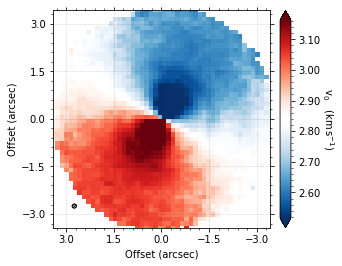

In [4]:
cube.plot_data()

There are a few other tools that may be useful for a quick inspection of the data described in [TBD](www.google.com).

### Fitting the Rotation Map

Here we describe how to fit the data using the `fit_map` function. For this introductory case, we assume a geometrically thin, Keplerian disk model where

$$v_0 = \sqrt{\frac{GM_{\rm star}}{r}} \cdot \cos \phi \cdot \sin i + v_{\rm LSR} \quad \text{or} \quad v_0 = v_{\rm kep} \cdot \cos \phi \cdot \sin i + v_{\rm LSR} $$

where $r$ is the cylindrical distance from the star (converted from angular distances in arcseconds to au by multiplying by the source distance, $d$), $\phi$ is the polar angle of the pixel (measured east of north relative to the redshifted major axis) and $v_{\rm LSR}$ is the systemic velocity.

For the fitting, we need to know which of these values we're fixing and which we want to fit for. Given the extreme degeneracy between $i$ and $M_{\rm star}$ for low inclination disks, a good idea is to either fix $i$ to a value found from fitting the continuum, or adopt a literature value for the dynamical mass. For this example we want to find the source center, $(x0,\,  y0)$, the position angle of the disk, ${\rm PA}$, the stellar mass $M_{\rm star}$ and the systemic velocity, $v_{\rm LSR}$, while holding the inclination fixed at $i = 5.8^{\circ}$, the value adopted in [Teague et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019ApJ...884L..56T/abstract).

Thus we have our free model parameters, $\Theta = \{x_0,\, y_0,\, {\rm PA},\, M_{\rm star},\,v_{\rm LSR}\}$, and our fixed model parameters, $\Theta_{\rm fixed} = \{i,\, d\}$.

We the provide two things to `fit_map`: 

* `p0`: a list of the initial guesses for the free parameters, $\Theta$.
* `params`: a dictionary containing both the indices of the free variables in `p0` as an **integer** and the fixed values for all other variables as a **float**.

With this dictionary framework it is possible to hold certain parameters fixed and others free. In particular, if you know the rotation direction of the disk (controlled by the sign of $i$, discussed in a later tutorial) then this is a good parameter to fix.

In [5]:
# Dictionary to contain the disk parameters.

params = {}

# Start with the free variables in p0.

params['x0'] = 0
params['y0'] = 1
params['PA'] = 2
params['mstar'] = 3
params['vlsr'] = 4

# Provide starting guesses for these values.

p0 = [0.0, 0.0, 151., 0.81, 2.8e3]

# Fix the other parameters. All values which are to be fixed must be floats.

params['inc'] = 5.8    # degrees
params['dist'] = 60.1   # parsec

The `fit_map` function has several steps:

1. Using the initial values in `p0` to deproject the data, it will create a mask of the regions to fit. Note that if the initial guesses are poor, the mask will not be well defined. This can be circumvented with the `niter` argument, [discussed later](#iterations).


2. If `optimize=True`, which is strongly recommended, it tries to find the values in `p0` which maximize the likelihood function. Using these updated `p0` values it will then recalculate the regions to fit.


3. It will the make any specified [diagnostic plots](#diagnostic_plots).


4. It will return any requested [products](#returned_products).

Assuming:
	p0 = [x0, y0, PA, mstar, vlsr].
Optimized starting positions:
	p0 = ['1.01e-02', '2.48e-02', '1.52e+02', '8.15e-01', '2.84e+03']


100%|██████████████████████████████████████| 1200/1200 [00:06<00:00, 179.68it/s]


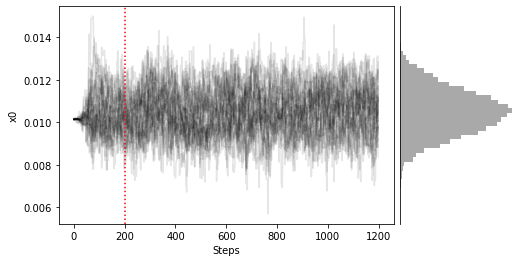

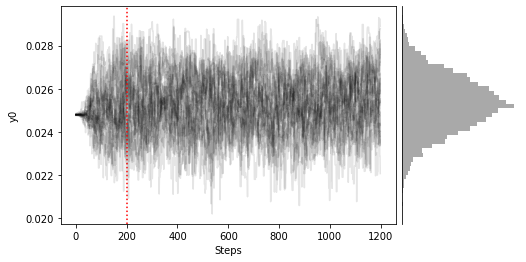

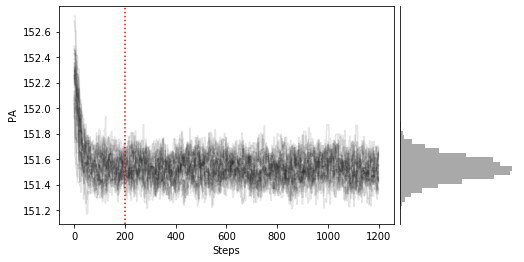

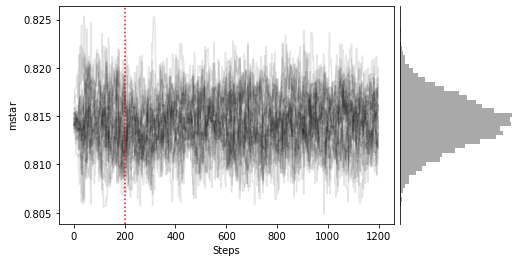

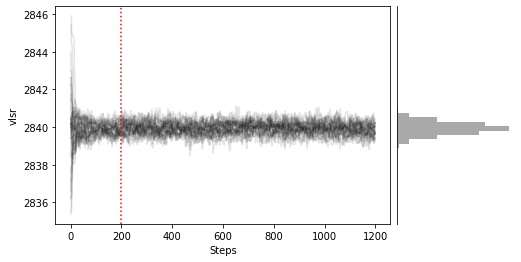

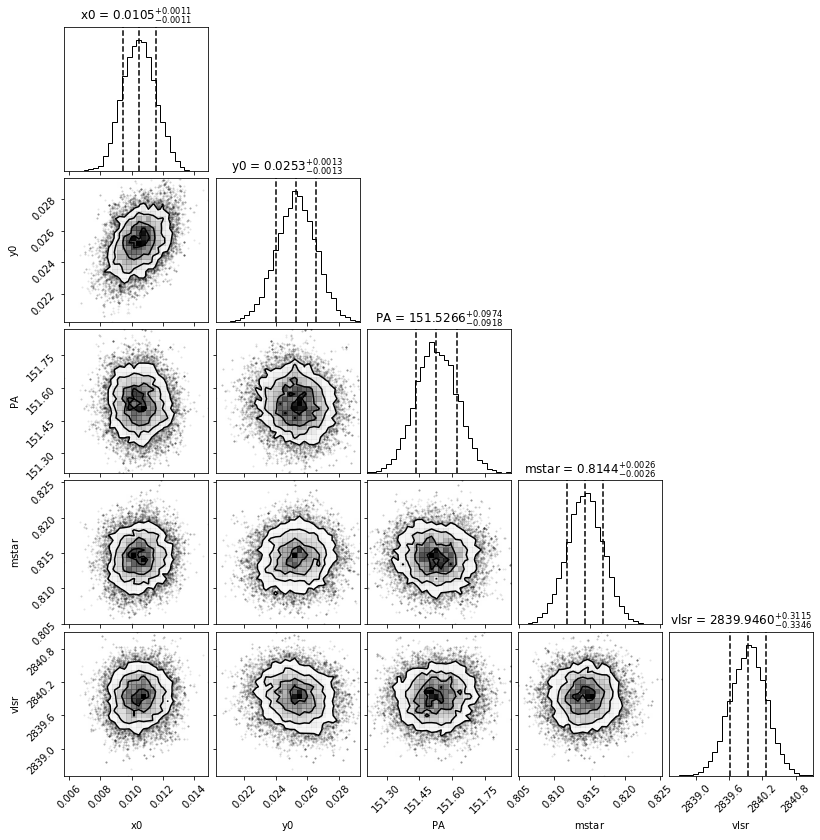

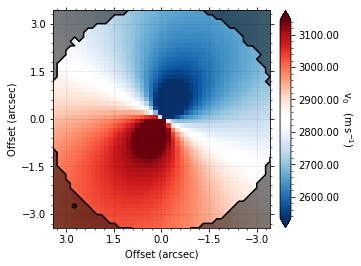

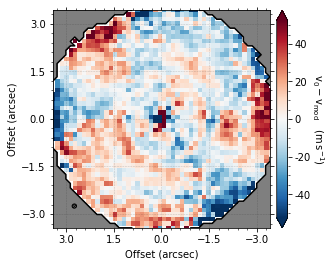

In [6]:
samples = cube.fit_map(p0=p0, params=params,
                       nwalkers=32, nburnin=200, nsteps=1000)

Note that through these tutorials, we use only a small number of steps for the MCMC as we just want to demonstrate the functionality of `eddy`. When using this for publishable results, it is strongly recommended to perform checks on the walkers to make sure they have sufficiently burnt in and are converged.

<a id='diagnostic_plots'></a>

#### Diagnostic Plots

By default, `fit_map` will produce all the diagnostic plots. You can select which plots you want using the `plots` argument, which takes either a single (string) value, or a list of strings. The available options are:


* `'walkers'` - Shows the traces of the walkers for each parameter. In each panel, the dashed red line shows the end of the burn-in period. The histogram shows the collapsed posterior distribution for all samples taken after the burn-in period.


* `'corner'` - A typical corner (covariance) plot using [corner.py](https://github.com/dfm/corner.py) from Dan Foreman-Mackey. The labels will show the median value with uncertainties representing the 16th to 84th percentile range.


* `'bestfit'` - A plot of the best-fit model (using the median value of the posteriors) with the mask overlaid.


* `'residual'` - A plot of the residuals between the data and the best fit model with the mask overlaid.


For example, if you wanted to just plot the residual you would use, `plots='residual'`, while for plots of the walkers and the corner plot you would use `plots=['walkers', 'corner']`. If you would like no plots, you can use `plots='none'` (careful to use a string here as `plots=None` is interpreted as the default of all plots).

<a id='returned_products'></a>

#### Returned Products

There are several different statistics or data products that can be returned after the MCMC, controlled with the `returns` argument. As for the plots, this takes either a single string or a list of strings. The available options are:

* `'samples'` - A `(nsteps, nparams)` shaped array of the posterior samples after the burn-in period. This has not been thinned, so must be done by hand if necessary.


* `'percentiles'` - A `(3, nparams)` shaped array of the 16th, 50th and 84th percentiles of each parameter's posterior distribution, a proxy of the standard deviation for a Gaussian distribution.


* `'lnprob'` - A `nsteps` sized array of the log-probability for each posteroir sample.


* `'model'` - A 2D array of the best-fit model using the median value from the samples.


* `'residuals'` - A 2D array of the residuals after subtracting the best-fit model from the data.


* `'dict'` - A `params` dictionary where the free parameters have been replaced with the median values of the posterior distributions.


By default `eddy` will just return the samples from the MCMC. 

<a id='masking_data'></a>

### Masking Data

Oftentimes it is useful to only fit a specific region of your rotation map, perhaps because you are only interested in a spatial radial region. Within `eddy`, you can define a map based on the disk-frame $(r,\, \phi)$ coordinates and / or on the value of $v_0$ to avoid cloud-contaminated velocities.

For each of these optionn, `r`, `phi` and `v`, you can specify the minimum and maximum value to include or exclude in your mask. For example, to only include the regions between $0.5^{\prime\prime}$ and $1.0^{\prime\prime}$ we would use,

```python
params['r_min'] = 0.5
params['r_max'] = 1.0
```

If instead we wanted to fit everywhere except a radial region between $0.5^{\prime\prime}$ and $1.0^{\prime\prime}$ and an azimuthal region  where $|\phi| \leq 30^{\circ}$ we would use,

```python
params['r_min'] = 1.0
params['r_max'] = 2.0
params['exclude_r'] = True
params['phi_min'] = -30.0
params['phi_max'] = 30.0
params['exclude_phi'] = True
```

In addition, there is the key `'abs_phi'` which will assume $\phi$ is mirrored about the major axis of the disk to aid in defining regions on either side of the minor axis, for example. Note that, as mentioned before, the mask generation will adopt the initial geometrical properties provided to the `fit_map` function. If these are wildly off the true values, the resulting mask will not be very good.

Assuming:
	p0 = [x0, y0, PA, mstar, vlsr].
Optimized starting positions:
	p0 = ['4.86e-02', '1.45e-02', '1.51e+02', '8.22e-01', '2.84e+03']


100%|██████████████████████████████████████| 1200/1200 [00:06<00:00, 178.10it/s]


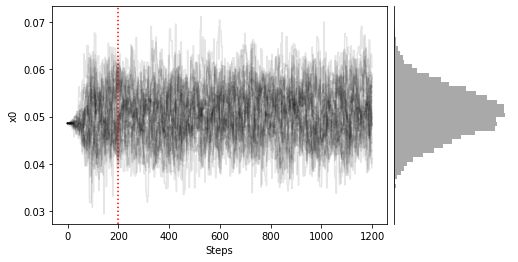

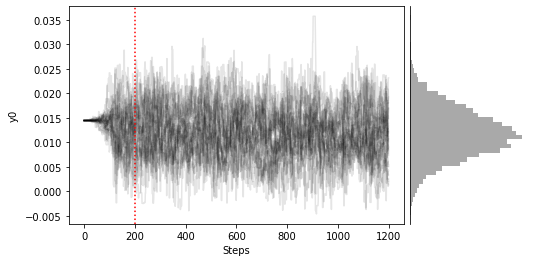

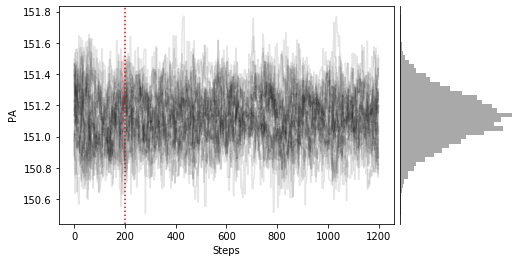

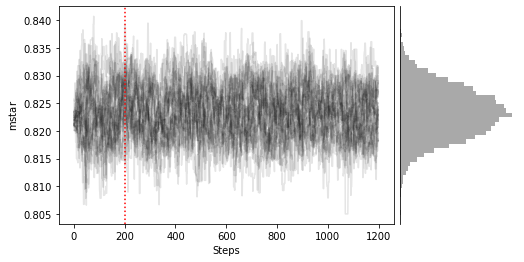

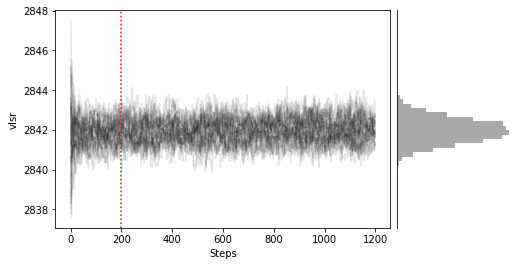

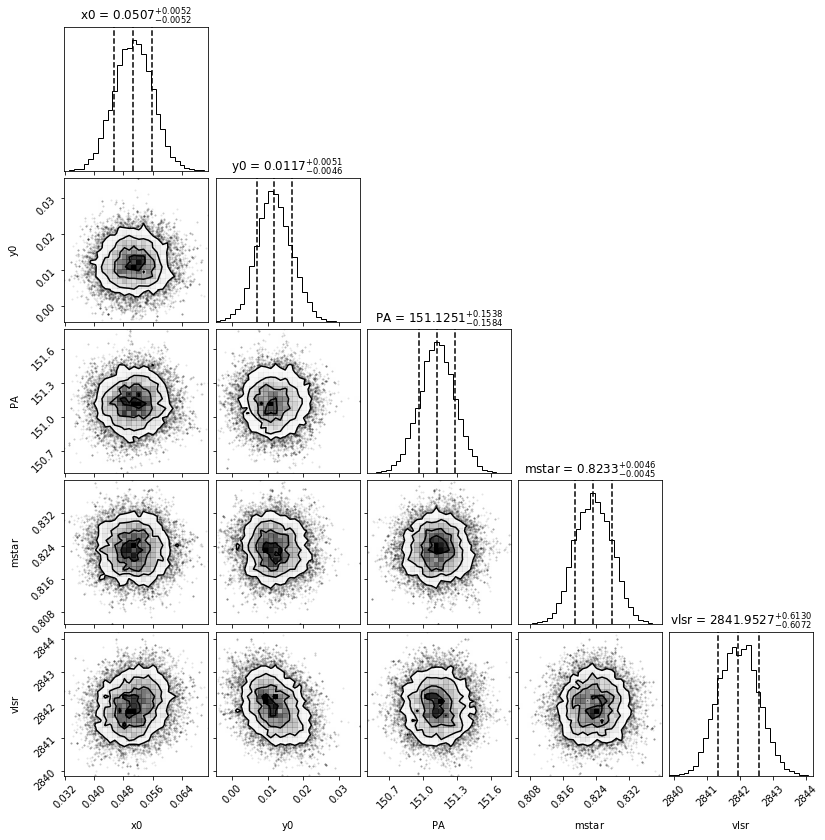

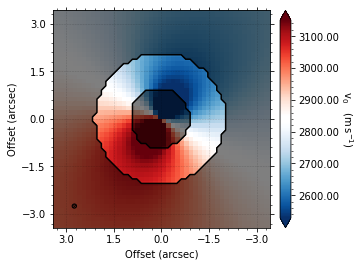

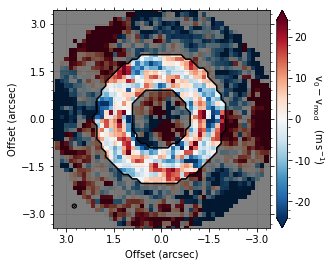

In [7]:
# fit only an annulus of points

params['r_min'] = 1.0
params['r_max'] = 2.0

samples = cube.fit_map(p0=p0, params=params,
                       nwalkers=32, nburnin=200, nsteps=1000,
                       plots=None)

As you can see here, the data is only fit to an annuli of points between $1^{\prime\prime}$ and $2^{\prime\prime}$, but the model is produced for the entire field of view. This is why choosing an appropriate `FOV` value will greatly speed up the fitting process.

<a id='iterations'></a>

### Iterations

As mentioned several times, the definition of the mask will depend on the initial guesses for your model parameters. Sometimes these are hard to guess, particularly with noisy data or if you're using an elevated emission surface ([see Tutorial 2](https://eddy.readthedocs.io/en/latest/tutorials/tutorial_2.html)). One brute-force approach for tackling this problem is to use the `niter` argument in `fit_map`. This will run `niter` iterations of the MCMC sampling, each time updating the `p0` values with the median values of the posteriors from the previous run. This should help nudge the `p0` values to more reasonable starting ones.

To demonstrate this, consider starting the attempt we had above with poor `p0` values.

Assuming:
	p0 = [x0, y0, PA, mstar, vlsr].


100%|██████████████████████████████████████| 1200/1200 [00:06<00:00, 184.12it/s]


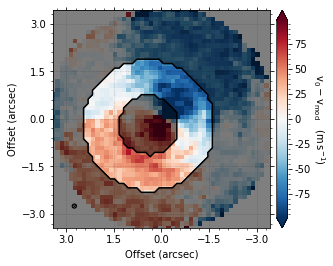

In [8]:
params = {}

params['x0'] = 0
params['y0'] = 1
params['PA'] = 2
params['mstar'] = 3
params['vlsr'] = 4

p0 = [0.4, -0.2, 54., 1.5, 2.3e3]

params['inc'] = 5.8
params['dist'] = 60.1
params['r_min'] = 1.0
params['r_max'] = 2.0

samples = cube.fit_map(p0=p0, params=params, optimize=False,
                       nwalkers=32, nburnin=200, nsteps=1000,
                       plots='residual')

Clearly this is not such a good fit. With enough time, the walkers should converge to the correct value (particularly as this is very good data), however they will still be fitting an incorrect disk region. Trying above, but now using `niter=2`, we can see this does a better job.

Assuming:
	p0 = [x0, y0, PA, mstar, vlsr].


100%|██████████████████████████████████████| 1200/1200 [00:06<00:00, 177.53it/s]


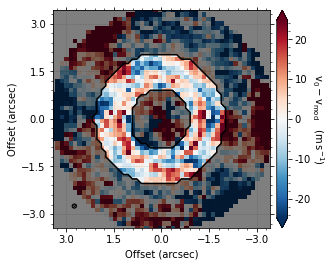

In [9]:
params = {}

params['x0'] = 0
params['y0'] = 1
params['PA'] = 2
params['mstar'] = 3
params['vlsr'] = 4

p0 = [0.4, -0.2, 54., 1.5, 2.3e3]

params['inc'] = 5.8
params['dist'] = 60.1
params['r_min'] = 1.0
params['r_max'] = 2.0

samples = cube.fit_map(p0=p0, params=params, optimize=False,
                       nwalkers=32, nburnin=200, nsteps=[200, 1000],
                       plots='residual', niter=2)

Here we have provided two values for `nsteps`, one for each of the iterations. `nwalkers`, `nburnin` and `nsteps` can accept lists of values that would be used for each iteration. It's important to note that `niter` should not be used in place of more walkers or steps, but rather to nuge things in the right direction.

<a id='Parallelization'></a>

### Parallelization

It's sometimes useful to parallelize the fitting. We can implement a naive approach using the `multiprocessing` package. We can provide a `pool` variable to `fit_map` which will interface with the MCMC. Note that this is implemented using the `with` statement so that it deals with the starting and closing of the pool.

---

__NOTE:__ It seems that currently the priors do not work correctly with parallelization. This is being investigated.

---

Assuming:
	p0 = [x0, y0, PA, mstar, vlsr].
Optimized starting positions:
	p0 = ['1.01e-02', '2.48e-02', '1.52e+02', '8.15e-01', '2.84e+03']


100%|██████████████████████████████████████| 1200/1200 [00:07<00:00, 166.62it/s]


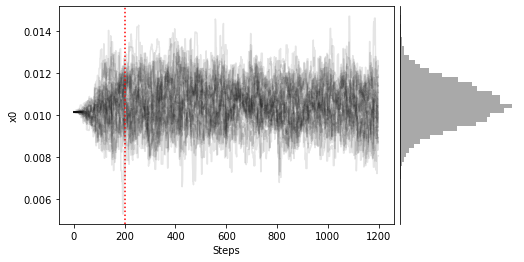

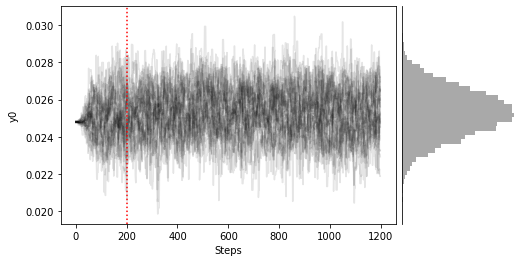

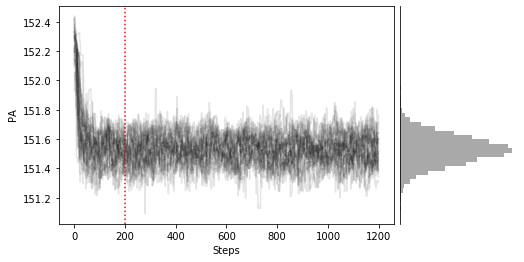

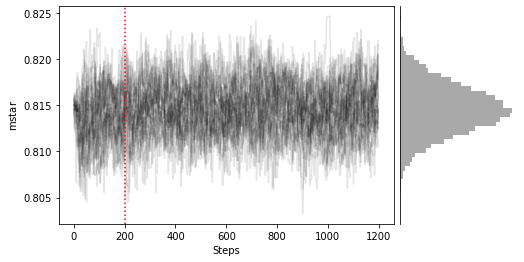

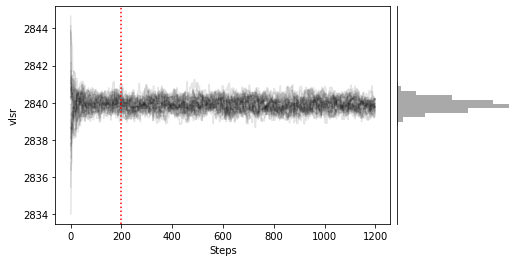

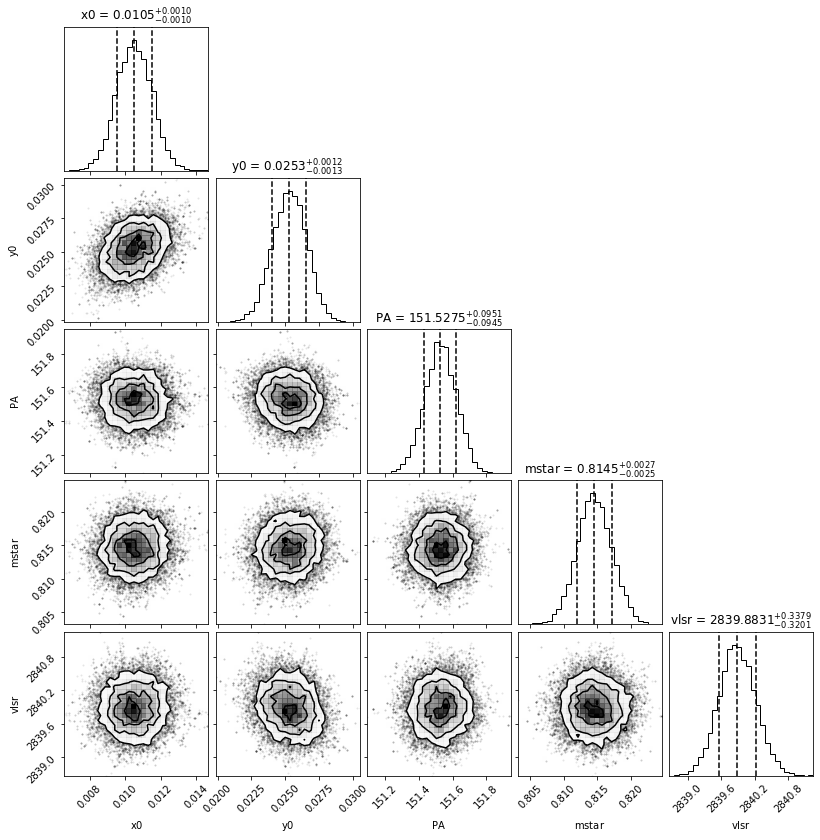

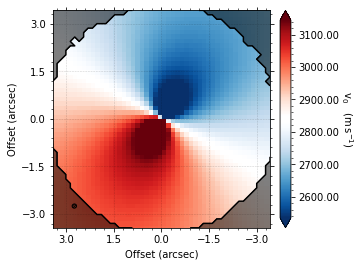

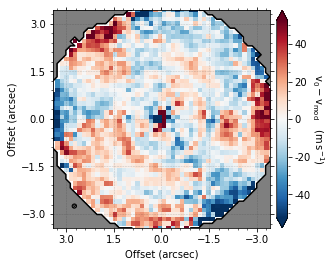

In [10]:
from multiprocessing import Pool

params = {}

params['x0'] = 0
params['y0'] = 1
params['PA'] = 2
params['mstar'] = 3
params['vlsr'] = 4

p0 = [0.0, 0.0, 151., 0.81, 2.8e3]

params['inc'] = 5.8
params['dist'] = 60.1

with Pool() as pool:
    cube.fit_map(p0=p0, params=params,
                 nwalkers=32, nburnin=200, nsteps=1000,
                 pool=pool)

You'll notice this is not substantially faster than the serial attempt because the whole class has to be pickled and read in and out, however we're able to run more walkers taking the same time. The improvement is more noticable for more complex models, either ones with an emission surface, or those with simply more pixels to fit.

<a id='MCMC_Packages'></a>

### MCMC Packages

By default `eddy` uses the `EnsemblerSampler` provided by [emcee](https://emcee.readthedocs.io/en/stable/). This can be changed to [zeus](https://zeus-mcmc.readthedocs.io/en/latest/) through the `mcmc` argument. To provide better control for the sampler, keyword arguments can be passed directly to the `EnsembleSampler` instance, for example to change the type of walker move.

Assuming:
	p0 = [x0, y0, PA, mstar, vlsr].
Optimized starting positions:
	p0 = ['1.01e-02', '2.48e-02', '1.52e+02', '8.15e-01', '2.84e+03']


Initialising ensemble of 32 walkers...
Sampling progress : 100%|███████████████████| 1200/1200 [00:34<00:00, 35.29it/s]


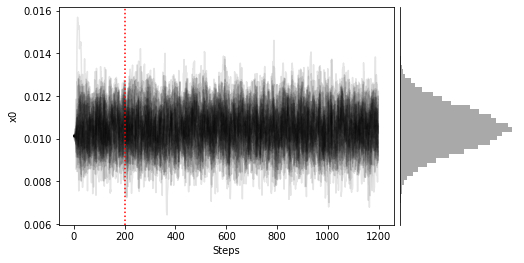

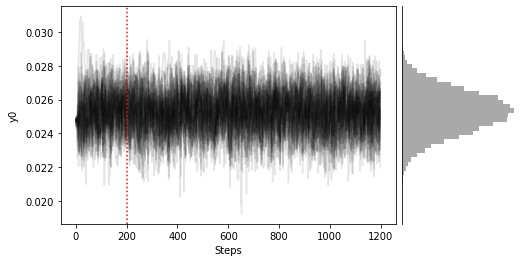

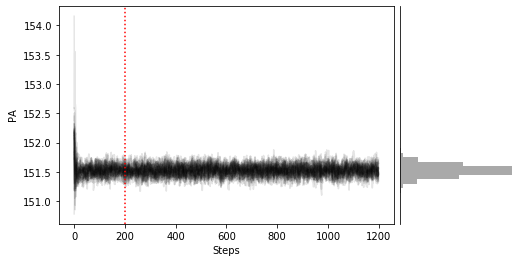

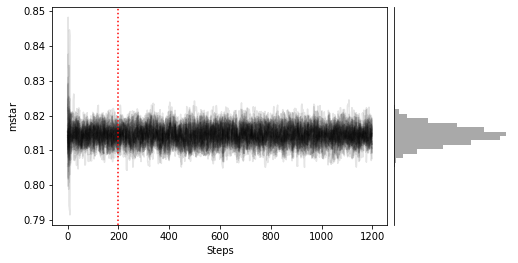

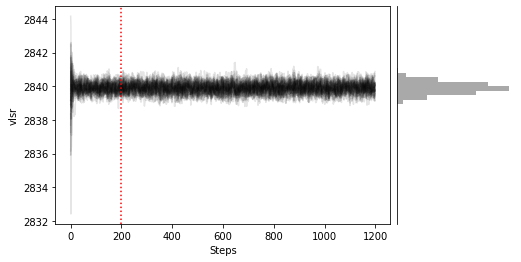

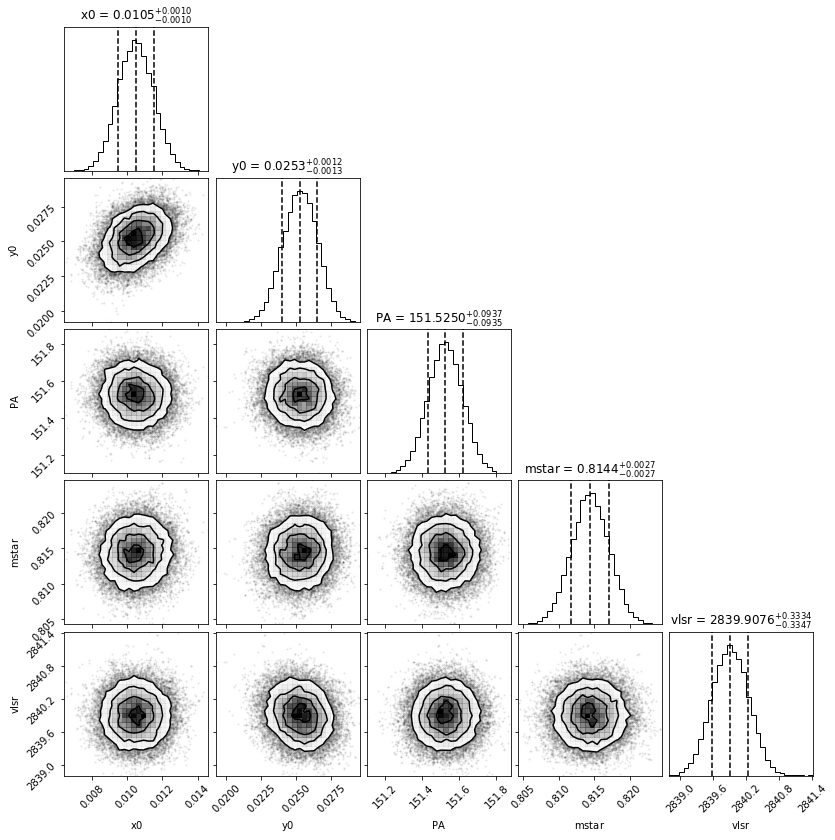

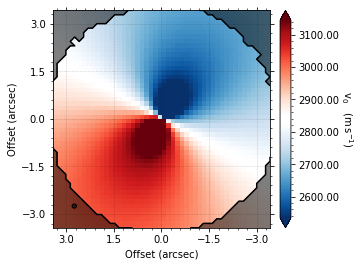

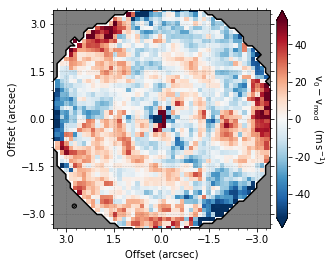

In [11]:
samples = cube.fit_map(p0=p0, params=params,
                       nwalkers=32, nburnin=200, nsteps=1000,
                       mcmc='zeus')

## Working with the Model

In the previous section we downsampled the cube to perform the fitting with spatially independent pixels (and to speed up the sampling). Once we have determined the samples, we can use another instance of a `rotationmap` without any downsampling to explore the models.

First, reload the data without any downsampling.

Assuming uncertainties in TWHya_CO_cube_dv0.fits.


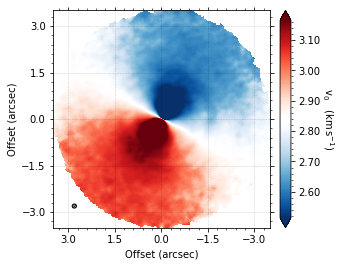

In [13]:
cube = rotationmap(path='TWHya_CO_cube_v0.fits', FOV=7.0)
cube.plot_data()

### Evaluating Models

To turn the samples returned from `fit_map` into a model, we use the `evaluate_models` function.

In [14]:
model = cube.evaluate_models(samples=samples, params=params)

This can then be plotted through the `plot_model` convenience function.

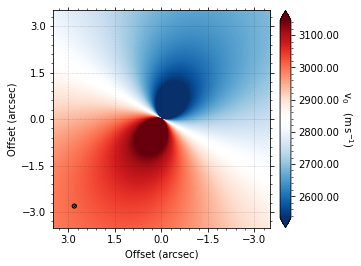

In [15]:
cube.plot_model(model=model)

Similarly, we can plot the residuals with respect to the original data through `plot_model_residuals`.

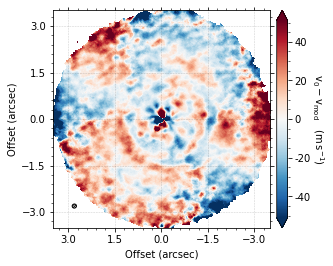

In [16]:
cube.plot_model_residual(model=model)

Both these functions can also directly take `samples` and `params` to skip the `evaluate_models` step. 

However, this approach, which is used to make the plots generated with `fit_map`, is that it is assumed that the model parameters are independent such that taking the median of each posterior distribution provides the 'best-fit' model. Often parameteres are correlated and it is better to generate several realizations of the model from the posterior samples and then combine them. This can be achieved with the `evaluate_models` function and the `draws` argument.

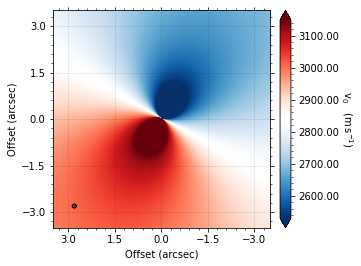

In [17]:
model = cube.evaluate_models(samples=samples, params=params, draws=100)
cube.plot_model(model=model)

Here the `draws` argument tells the function how many random draws to take which are then averaged down to a single value. If `draws` is less than 1, this represents the percentile of the posteriors to use (e.g., `draws=0.5` will use the median values from all posterior distributions).

In addition, the `evaluate_models` function also allows for a user-defined function to collapse the multiple models, `collapse_func`. This is particularly useful if you want to see how much variability there is in the sample of models by looking at the standard deviation of the set. Note here how you can provide extra kwargs to the `imshow` function to display the data.

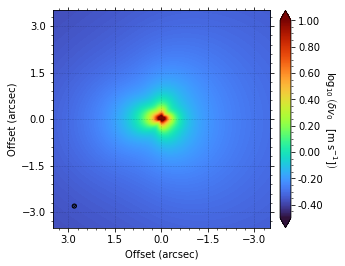

In [18]:
scatter = cube.evaluate_models(samples=samples, params=params, draws=100, collapse_func=np.std)

cube.plot_model(model=np.log10(scatter),
                imshow_kwargs=dict(cmap='turbo', vmin=-0.5, vmax=1.0),
                cb_label=r'$\log_{10}\,\left(\delta v_0 \quad [{\rm m\,s^{-1}}] \right)$')

From this you can clearly see that there are small variations between the models in the posterior samples, but these are typically confined to the inner region of the disk.

### Saving Models

If you want to save the model for use later, you can export it as a FITS cube, copying the header information from the attached FITS cube. As with `evaluate_models`, `save_model` accepts either the `samples` and `params`, or a pre-evaluated `model`.

In [18]:
cube.save_model(model=model)

---

**NOTE** If the datacube has been clipped down using the `FOV` argument when loading the cube, the model will only populate pixels in that subregion. The rest will be left as `NaN`.

---